<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/MiniProject_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our group's Mini Project uses the same data that we explored during [Lab 1](https://nbviewer.jupyter.org/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb), which you'll recall came from the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 [Kaggle](https://www.kaggle.com/usdot/flight-delays). 

Our logistic regression and support vector machine models will focus on classifying flights using arrival delay as our response variable. As we noted in Lab 1's Business Understanding section, "Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air."

## 1. Logistic Regression & Support Vector Machine Models

> [50 points] Create a logistic regression model and a support vector machine model for the
classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### 1.1 Setup & Load Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on we will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = ["WHEELS_OFF",  
        "WHEELS_ON"] 
df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME"]
df[cols] = df[cols].apply(pd.to_numeric)

### 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we will create buckets where appropriate to analyze similar attributes together. 

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp. Because we are trying to predict arrivals we would not have access to the `ARRIVAL_TIME` data.

- **Overnight**: 12:00am - 4:00am
- **Morning**: 4:00am - 11:00am
- **Afternoon**: 11:00am - 4:00pm
- **Evening**: 4:00pm - 12:00am

[Flight] `DISTANCE` is also divided into buckets.

- **Short**: 1-99 miles
- **Medium**: 100-999 miles
- **Long**: 1,000+ miles

In [3]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,evening,morning,Long
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,overnight,overnight,morning,Long
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,overnight,overnight,Long


In [4]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', dist_bucket)

morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64


### 1.3 Missing Values

In [5]:
%%time
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

CPU times: user 1min 15s, sys: 1.58 s, total: 1min 17s
Wall time: 1min 17s


### 1.4 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [6]:
# Log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [7]:
# These columns required log transformations to normalize the data therefore removed prior variable.
col_to_drop = ['DEPARTURE_DELAY','ARRIVAL_DELAY','DISTANCE','TAXI_IN',
               'ELAPSED_TIME', 'AIR_TIME']
df = df.drop(columns = col_to_drop)

In [8]:
# Check our current columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5717223 entries, 0 to 5819078
Data columns (total 36 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  TAXI_OUT               float64 
 12  WHEELS_OFF             object  
 13  SCHEDULED_TIME         object  
 14  WHEELS_ON              object  
 15  SCHEDULED_ARRIVAL      int64   
 16  ARRIVED                float64 
 17  DIVERTED               int64   
 18  CANCELLED              int64   
 19  CANCELLATION_REASON    object  
 20  AIR_SYSTEM_DELAY       float64 
 21  SECURITY_DELAY         float64 

In [9]:
# Look at the head of all columns
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


In [10]:
# Convert scheduled time to be a numeric instead of an object.
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

### 1.5 Remove Non-Cancelled Flights

Flights that are cancelled will, by their nature, not have an arrival delay. Therefore we remove those so that we are left with only the flights that were completed. 

In [11]:
df = df[df.CANCELLED == 0]

In [12]:
df.shape

(5713499, 36)

In [13]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.6 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:
- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have `AIRLINE_CODE` which is the same information
- `CANCELLATION_REASON` and `CANCELLED`: We are looking at delays only so do not need cancellation details.
- `WHEELS_ON` and `WHEELS_OFF`: We made these binary instead of a time stamp, but this is no longer needed when we are looking at flights being delayed, as these values will all be `1`
- `DEPARTED` and `ARRIVED`: Again, these are binary values and are not needed as all will be equal to `1` after removing the cancelled flights



In [14]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [15]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,1,1,4,AS,98,N407AS,ANC,SEA,21.0,205,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,12.0,280,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,1,1,4,US,840,N171US,SFO,CLT,16.0,286,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,1,1,4,AA,258,N3HYAA,LAX,MIA,15.0,285,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,1,1,4,AS,135,N527AS,SEA,ANC,11.0,235,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.7 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [16]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N7LEAA       1
N180UA       1
N860NW       1
N7LBAA       1
N840MH       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343479
ORD      276544
DFW      232635
DEN      193345
LAX      191939
          ...  
11905         1
13502         1
15497         1
14222         1
11097         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343052
ORD      275834
DFW      231744
DEN      193030
LAX      192128
          ...  
14025         1
10666         1
11097         1
12265         1
14222         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (`TAIL_NUMBER`) and 929 different airports (`ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 for the origin and destination airports so that we have a greater likelihood of including it within either the train or test set.

In [17]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N705DN       5
N857NW       5
N831MH       5
N176DZ       5
N859NW       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343459
ORD      276537
DFW      232632
DEN      193345
LAX      191919
          ...  
11778        10
11146        10
13061        10
12003        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      343032
ORD      275825
DFW      231738
DEN      193030
LAX      192110
          ...  
11146        10
10208        10
16218        10
11624        10
11778        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns on a 5 million row data set without moving to a cloud-based solution.

In [18]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

CPU times: user 6.44 s, sys: 1.72 s, total: 8.16 s
Wall time: 8.43 s


For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [19]:
%%time

categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'DISTANCE_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

CPU times: user 7.71 s, sys: 2.82 s, total: 10.5 s
Wall time: 10.5 s


,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long
0,1,1,4,98,21.0,205,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,1,1,4,2336,12.0,280,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,1,1,4,840,16.0,286,0,0.0,0.0,0.0,0.0,0.0,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,1,1,4,258,15.0,285,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1,1,4,135,11.0,235,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [20]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 50 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   SCHEDULED_TIME                   int64  
 6   DIVERTED                         int64  
 7   AIR_SYSTEM_DELAY                 float64
 8   SECURITY_DELAY                   float64
 9   AIRLINE_DELAY                    float64
 10  LATE_AIRCRAFT_DELAY              float64
 11  WEATHER_DELAY                    float64
 12  DEPARTURE_DELAY_log              float64
 13  ARRIVAL_DELAY_Log                float64
 14  DISTANCE_log                     float64
 15  TAXI_IN_Log                      float64
 16  ELAPSED_TIME_log                 float64
 17  AIR_TIME

### 1.8 Create Response Variable

In [21]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df_OHE['DELAYED'] = df_OHE.ARRIVAL_DELAY_Log.apply(get_delay)
df_OHE = df_OHE.drop(columns = 'ARRIVAL_DELAY_Log')
df_OHE.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,DELAYED
0,1,1,4,98,21.0,205,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.609438,5.273000,5.135798,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,1,1,4,2336,12.0,280,0,0.0,0.0,0.0,0.0,0.0,0.0,7.754053,1.609438,5.634790,5.575949,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,1,1,4,840,16.0,286,0,0.0,0.0,0.0,0.0,0.0,0.0,7.739359,2.484907,5.683580,5.587249,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
3,1,1,4,258,15.0,285,0,0.0,0.0,0.0,0.0,0.0,0.0,7.759187,2.197225,5.641907,5.556828,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,1,1,4,135,11.0,235,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.791759,5.375278,5.298317,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [22]:
# Check the response variable distribution
df_OHE['DELAYED'].value_counts()

0    3626052
1    2086178
Name: DELAYED, dtype: int64

### 1.9 Check Correlations

<AxesSubplot:>

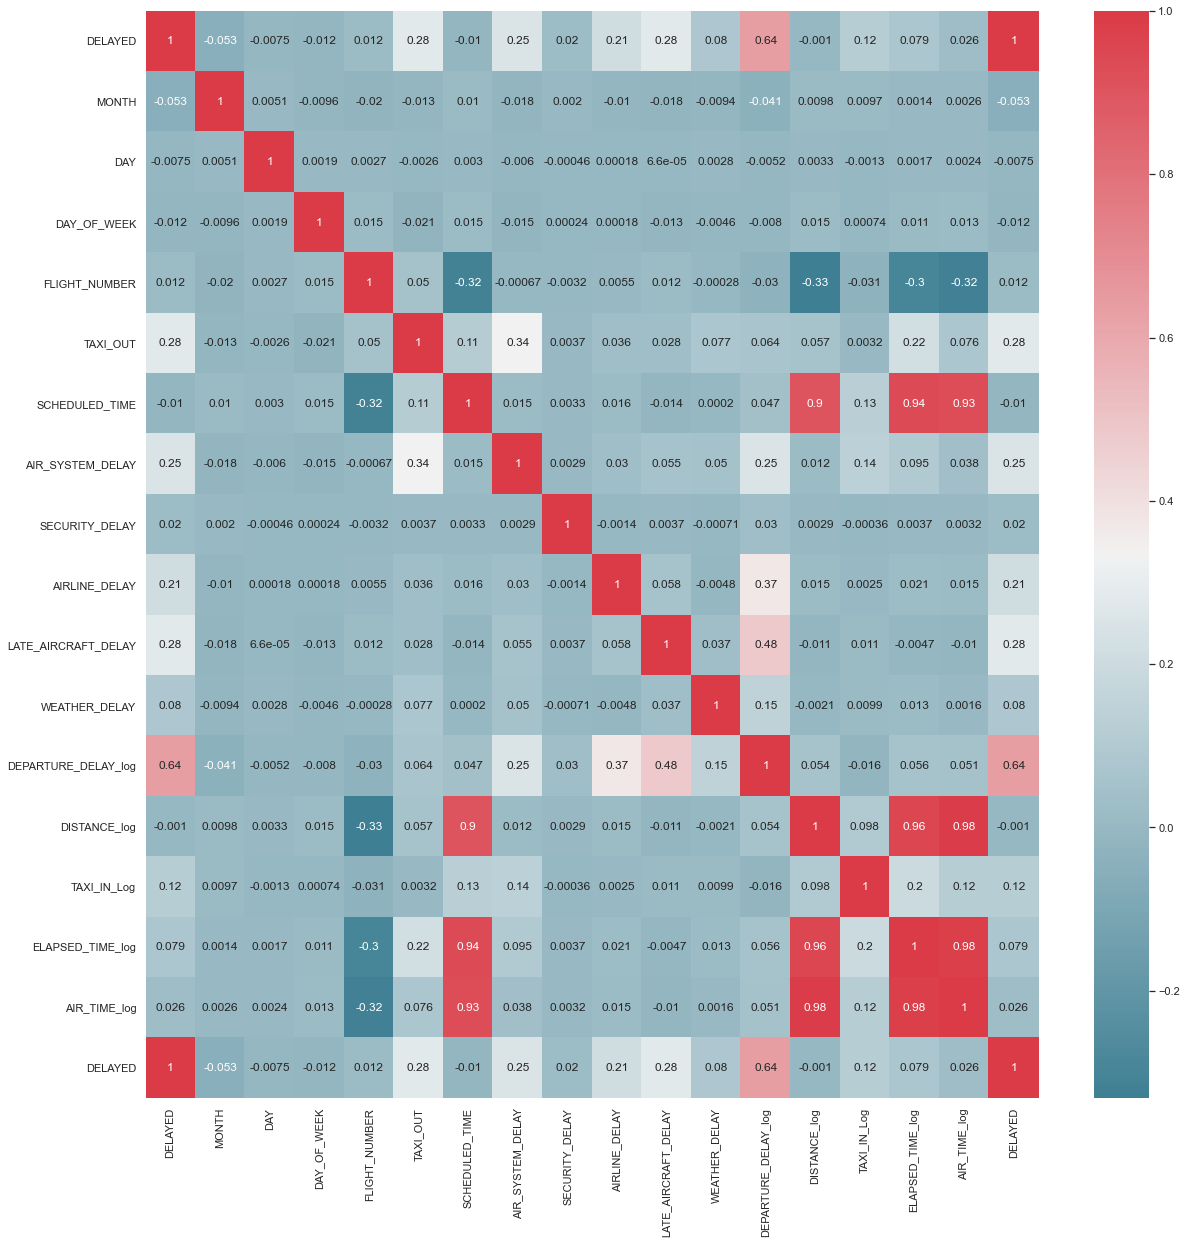

In [23]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for response and continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','SCHEDULED_TIME',
           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log','DELAYED']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME_log`, `AIR_TIME_log`, `DISTANCE_log` are all highly correlated. For the purposes here we want to only keep `DISTANCE_log`, the decision to keep this variable was that we would not know the Air Time and Elapsed Time since we are trying to predict if the plane would be delayed prior to flight and distance would always be known. 

In [24]:
# Drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME_log', 'AIR_TIME_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

<AxesSubplot:>

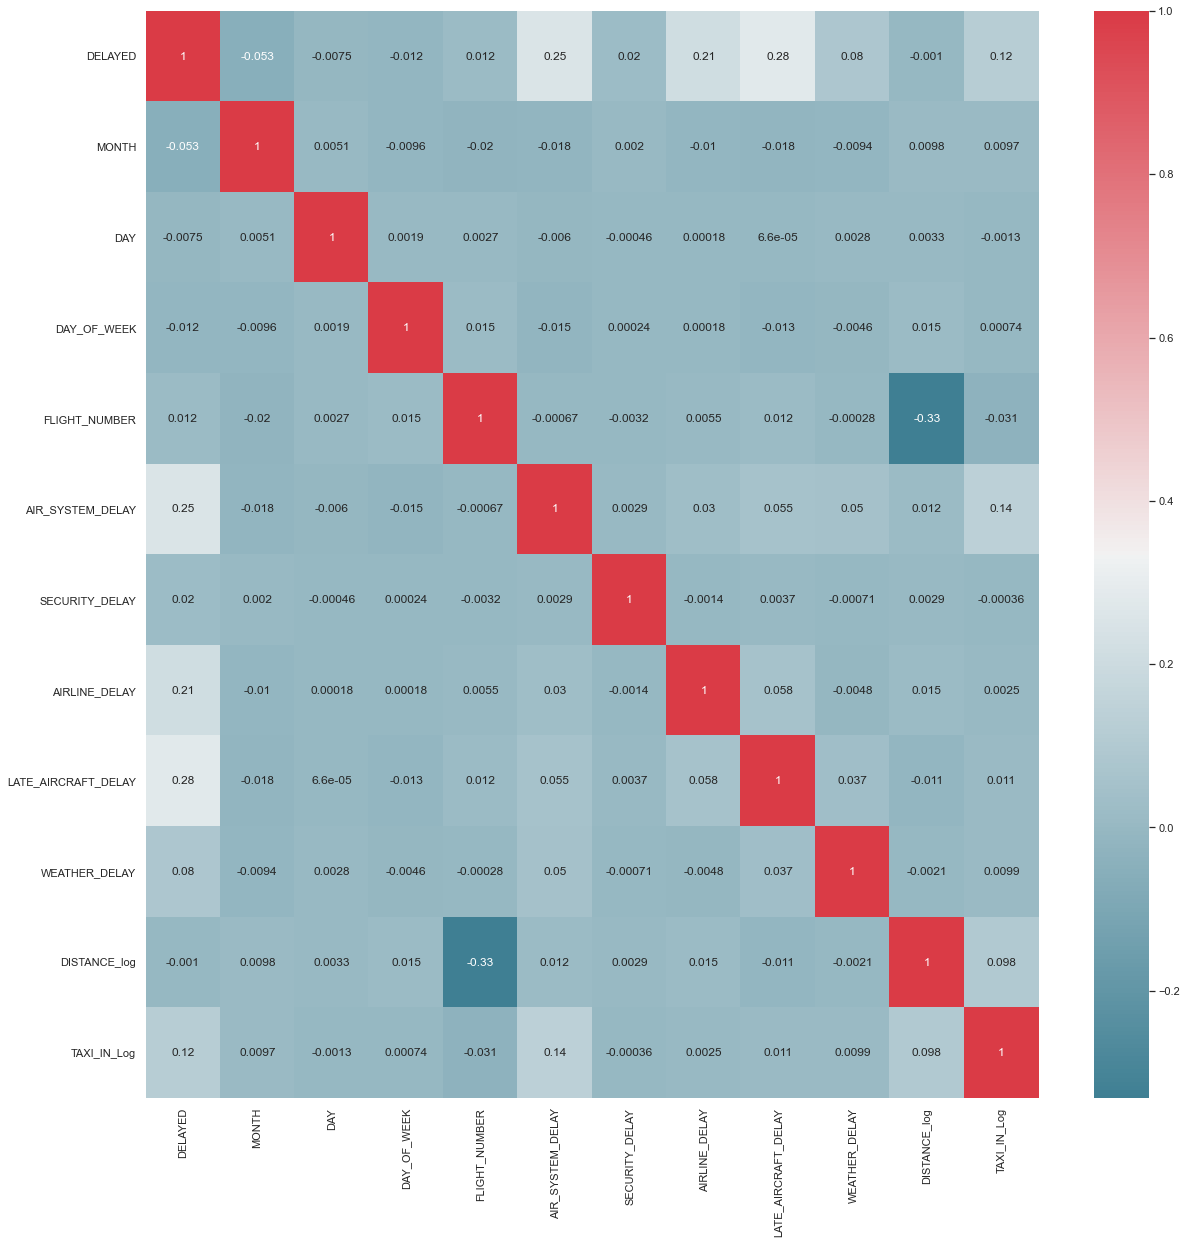

In [25]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for the remaining continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
         'DISTANCE_log', 'TAXI_IN_Log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [26]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 47 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   DIVERTED                         int64  
 6   AIR_SYSTEM_DELAY                 float64
 7   SECURITY_DELAY                   float64
 8   AIRLINE_DELAY                    float64
 9   LATE_AIRCRAFT_DELAY              float64
 10  WEATHER_DELAY                    float64
 11  DEPARTURE_DELAY_log              float64
 12  DISTANCE_log                     float64
 13  TAXI_IN_Log                      float64
 14  ORIGIN_AIRPORT_encode            int64  
 15  DESTINATION_AIRPORT_encode       float64
 16  TAIL_NUMBER_encode               int64  
 17  AIRLINE_

The `AIRLINE_CODE_`, `SCHED_DEPARTURE_TIME_`, `ACTUAL_DEPARTURE_TIME_`, and `SCHED_ARRIVAL_TIME_` one-hot encodings are returning perfect multicollinearity so we'll remove one of each and re-run the VIF. After thinking this through, it makes sense that the actual departure and arrival times are a dead giveaway for delays. Same with our other delay types (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`, and ARRIVAL_DELAY buckets). Logically, the airline code and the scheduled times shouldn't impact our VIF, so let's remove the delay types and re-run VIF to confirm.

In [27]:
# %%time
# # Re-run our VIF code
# # Calculate the VIF
# # Source: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/

# # Import library for VIF
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

# X = df_OHE.iloc[:,:-13] # 13 is the current location of the "Delayed" response variable
# calc_vif(X)

In [28]:
# Drop the remaining highly correlated variables DISTANCE, TAXI_IN, ARRIVAL_DELAY, and ARRIVAL_DELAY_Log
col_to_drop4 = ['ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening', 'ACTUAL_DEPARTURE_TIME_overnight', 
                 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_OHE = df_OHE.drop(columns = col_to_drop4)

df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

### 1.10 Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival.

In [29]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

In [31]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    del df_final['DELAYED'] # get rid of the class label
    X = df_final.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# To use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits.
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [32]:
features = list(df_final)
features

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'FLIGHT_NUMBER',
 'TAXI_OUT',
 'DIVERTED',
 'DEPARTURE_DELAY_log',
 'DISTANCE_log',
 'TAXI_IN_Log',
 'ORIGIN_AIRPORT_encode',
 'DESTINATION_AIRPORT_encode',
 'TAIL_NUMBER_encode',
 'AIRLINE_CODE_AA',
 'AIRLINE_CODE_AS',
 'AIRLINE_CODE_B6',
 'AIRLINE_CODE_DL',
 'AIRLINE_CODE_EV',
 'AIRLINE_CODE_F9',
 'AIRLINE_CODE_HA',
 'AIRLINE_CODE_MQ',
 'AIRLINE_CODE_NK',
 'AIRLINE_CODE_OO',
 'AIRLINE_CODE_UA',
 'AIRLINE_CODE_US',
 'AIRLINE_CODE_VX',
 'AIRLINE_CODE_WN',
 'SCHED_DEPARTURE_TIME_overnight',
 'SCHED_DEPARTURE_TIME_morning',
 'SCHED_DEPARTURE_TIME_afternoon',
 'SCHED_DEPARTURE_TIME_evening',
 'SCHED_ARRIVAL_TIME_overnight',
 'SCHED_ARRIVAL_TIME_morning',
 'SCHED_ARRIVAL_TIME_afternoon',
 'SCHED_ARRIVAL_TIME_evening',
 'DISTANCE_BUCKET_Short',
 'DISTANCE_BUCKET_Medium',
 'DISTANCE_BUCKET_Long']

### 1.11 Lasso Regression

In [33]:
#alternate test/train split for use in lasso regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

grid = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, #test values of alpha from 0.1 to 10
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [35]:
# Run grid search
grid.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ...............................model__alpha=0.1; total time=   7.7s
[CV 2/5] END ...............................model__alpha=0.1; total time=   7.6s
[CV 3/5] END ...............................model__alpha=0.1; total time=   7.4s
[CV 4/5] END ...............................model__alpha=0.1; total time=   7.5s
[CV 5/5] END ...............................model__alpha=0.1; total time=   7.3s
[CV 1/5] END ...............................model__alpha=0.2; total time=   6.2s
[CV 2/5] END ...............................model__alpha=0.2; total time=   6.3s
[CV 3/5] END ...............................model__alpha=0.2; total time=   7.5s
[CV 4/5] END ...............................model__alpha=0.2; total time=   7.2s
[CV 5/5] END ...............................model__alpha=0.2; total time=   7.3s
[CV 1/5] END ...............model__alpha=0.30000000000000004; total time=   7.3s
[CV 2/5] END ...............model__alpha=0.3000

[CV 2/5] END ...............................model__alpha=2.1; total time=   7.1s
[CV 3/5] END ...............................model__alpha=2.1; total time=   7.1s
[CV 4/5] END ...............................model__alpha=2.1; total time=   7.0s
[CV 5/5] END ...............................model__alpha=2.1; total time=   7.0s
[CV 1/5] END ...............................model__alpha=2.2; total time=   6.9s
[CV 2/5] END ...............................model__alpha=2.2; total time=   7.0s
[CV 3/5] END ...............................model__alpha=2.2; total time=   6.8s
[CV 4/5] END ...............................model__alpha=2.2; total time=   6.9s
[CV 5/5] END ...............................model__alpha=2.2; total time=   7.0s
[CV 1/5] END ................model__alpha=2.3000000000000003; total time=   7.0s
[CV 2/5] END ................model__alpha=2.3000000000000003; total time=   7.1s
[CV 3/5] END ................model__alpha=2.3000000000000003; total time=   7.0s
[CV 4/5] END ...............

[CV 4/5] END ...............................model__alpha=4.1; total time=   5.5s
[CV 5/5] END ...............................model__alpha=4.1; total time=   5.7s
[CV 1/5] END ...............................model__alpha=4.2; total time=   7.0s
[CV 2/5] END ...............................model__alpha=4.2; total time=   6.9s
[CV 3/5] END ...............................model__alpha=4.2; total time=   7.0s
[CV 4/5] END ...............................model__alpha=4.2; total time=   7.0s
[CV 5/5] END ...............................model__alpha=4.2; total time=   6.9s
[CV 1/5] END ...............................model__alpha=4.3; total time=   5.6s
[CV 2/5] END ...............................model__alpha=4.3; total time=   5.7s
[CV 3/5] END ...............................model__alpha=4.3; total time=   7.0s
[CV 4/5] END ...............................model__alpha=4.3; total time=   6.9s
[CV 5/5] END ...............................model__alpha=4.3; total time=   7.0s
[CV 1/5] END ...............

[CV 1/5] END ...............................model__alpha=6.2; total time=   7.1s
[CV 2/5] END ...............................model__alpha=6.2; total time=   7.1s
[CV 3/5] END ...............................model__alpha=6.2; total time=   7.1s
[CV 4/5] END ...............................model__alpha=6.2; total time=   7.2s
[CV 5/5] END ...............................model__alpha=6.2; total time=   7.2s
[CV 1/5] END ...............................model__alpha=6.3; total time=   7.2s
[CV 2/5] END ...............................model__alpha=6.3; total time=   7.2s
[CV 3/5] END ...............................model__alpha=6.3; total time=   7.3s
[CV 4/5] END ...............................model__alpha=6.3; total time=   7.3s
[CV 5/5] END ...............................model__alpha=6.3; total time=   7.1s
[CV 1/5] END ...............................model__alpha=6.4; total time=   7.2s
[CV 2/5] END ...............................model__alpha=6.4; total time=   7.2s
[CV 3/5] END ...............

[CV 3/5] END ...............................model__alpha=8.2; total time=   6.8s
[CV 4/5] END ...............................model__alpha=8.2; total time=   5.9s
[CV 5/5] END ...............................model__alpha=8.2; total time=   5.6s
[CV 1/5] END ...............................model__alpha=8.3; total time=   5.6s
[CV 2/5] END ...............................model__alpha=8.3; total time=   5.6s
[CV 3/5] END ...............................model__alpha=8.3; total time=   5.6s
[CV 4/5] END ...............................model__alpha=8.3; total time=   5.5s
[CV 5/5] END ...............................model__alpha=8.3; total time=   6.0s
[CV 1/5] END ...............................model__alpha=8.4; total time=   6.9s
[CV 2/5] END ...............................model__alpha=8.4; total time=   6.9s
[CV 3/5] END ...............................model__alpha=8.4; total time=   6.9s
[CV 4/5] END ...............................model__alpha=8.4; total time=   6.9s
[CV 5/5] END ...............

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [36]:
# Find the best value of alpha
grid.best_params_

{'model__alpha': 0.1}

In [37]:
# Find coefficients
coefficients = grid.best_estimator_.named_steps['model'].coef_
coefficients

array([-0.        , -0.        , -0.        ,  0.        ,  0.02022535,
        0.        ,  0.20646438, -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ])

In [38]:
# Find the most important features
np.array(features)[coefficients > 0]

array(['TAXI_OUT', 'DEPARTURE_DELAY_log'], dtype='<U30')

### 1.12 Logistic Regression

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Define our model
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None,
                            solver='liblinear')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8567582187692022
confusion matrix
 [[667215  58317]
 [105329 311585]]
====Iteration 1  ====
accuracy 0.8542486909665752
confusion matrix
 [[665588  59226]
 [107287 310345]]
====Iteration 2  ====
accuracy 0.8539204478811252
confusion matrix
 [[665339  59523]
 [107365 310219]]


Code below adapted from class notebook.

In [40]:
# Create new CV object for our split
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

In [41]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8460977586686811
CPU times: user 23.3 s, sys: 1.76 s, total: 25.1 s
Wall time: 23.6 s


In [42]:
#re-run with 10 iterations

regularize_const = 0.1
iterations = 10

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.846621196975612


In [43]:
#test use 10-fold cv object
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=10, test_size=0.2, train_size=None)


In [44]:
%%time

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8457966503449617
CPU times: user 4min 27s, sys: 15.9 s, total: 4min 42s
Wall time: 4min 28s


In [45]:
# Iterate over the coefficients and interpret the weights
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.038797599170358014
DAY has weight of -0.004623126306503656
DAY_OF_WEEK has weight of -0.04385247087119074
FLIGHT_NUMBER has weight of -7.59740712945918e-05
TAXI_OUT has weight of 0.14440912141348514
DIVERTED has weight of 0.0
DEPARTURE_DELAY_log has weight of 1.3835071958547434
DISTANCE_log has weight of -0.7834401193502253
TAXI_IN_Log has weight of 1.2640142375703283
ORIGIN_AIRPORT_encode has weight of -0.00017570924085896837
DESTINATION_AIRPORT_encode has weight of -5.4709487344050986e-05
TAIL_NUMBER_encode has weight of -5.5895713850256134e-05
AIRLINE_CODE_AA has weight of -0.29938612084960503
AIRLINE_CODE_AS has weight of 0.2598784670722486
AIRLINE_CODE_B6 has weight of -0.08470729452729653
AIRLINE_CODE_DL has weight of -0.6103974083303252
AIRLINE_CODE_EV has weight of 0.06202992837054908
AIRLINE_CODE_F9 has weight of 0.1368788611539189
AIRLINE_CODE_HA has weight of 0.16193697385480935
AIRLINE_CODE_MQ has weight of -0.14197844346235866
AIRLINE_CODE_NK has wei

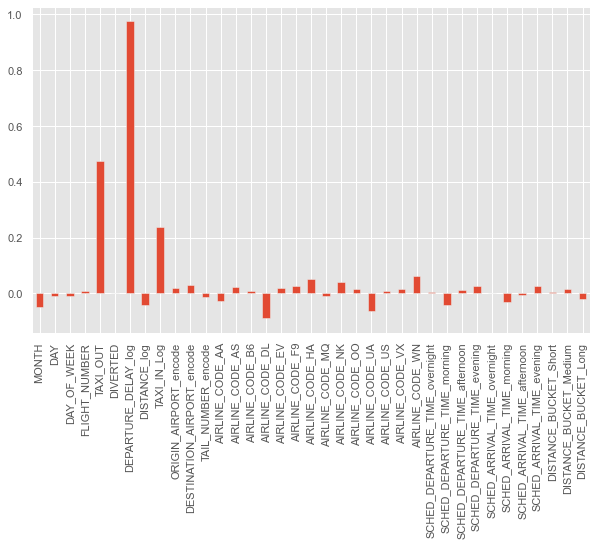

In [46]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(10,6))

weights = pd.Series(log_sgd.coef_[0],index=df_final.columns)
weights.plot(kind='bar')
plt.show()

### 1.13 SVM

#### 1.13.1

Run 'out of the box' SVM. Note that we have not scaled the data. Our data is all roughly on the same scale to begin with and should not be necessary.

In [47]:
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM Accuracy:', acc)
print(conf)

SVM Accuracy: 0.839788488908885
[[677329  48147]
 [134886 282084]]


#### 1.13.2 Using Code From 04. Logits and SVM

In [48]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_svm = df_OHE[cols+['DELAYED']]

# Sample our data to model off a smaller data set
df_svm_sample = df_svm.sample(frac = 0.01, replace = False, random_state = 42)

In [49]:
# We want to predict the X and y data as follows:
if 'DELAYED' in df_svm_sample:
    y = df_svm_sample['DELAYED'].values # get the labels we want
    del df_svm_sample['DELAYED'] # get rid of the class label
    X = df_svm_sample.values # use everything else to predict!
    
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

StandardScaler()

In [51]:
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [52]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8615317286652079
[[6776  456]
 [1126 3067]]


In [53]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(16675, 37)
(16675,)
[8447 8228]


#### 1.13.3 SVM with Linear Kernel

In [54]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8533916849015317
[[6698  534]
 [1141 3052]]


In [55]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(15880, 37)
(15880,)
[7946 7934]


[[-4.28934216e-02 -7.92651515e-03 -3.17118795e-03 -5.26425436e-03
   7.83887123e-01  0.00000000e+00  1.41759274e+00 -1.16591443e-01
   3.60998116e-01  1.05518005e-02  4.45516702e-05 -1.70778439e-02
  -6.13218304e-02  6.43168976e-02  4.33233984e-03 -1.13347967e-01
   2.98960151e-02  2.98276827e-02  9.19435991e-02 -6.31947774e-03
   5.70522907e-02  1.02352238e-02 -1.64708105e-01 -1.39658012e-02
   2.46535463e-02  1.51594406e-01  5.22205741e-03 -1.91747326e-02
   6.73310746e-03  1.21215223e-02 -1.29588385e-02  5.61223650e-03
   1.08564274e-02 -1.14953331e-02 -1.06053989e-02  3.05426577e-02
  -2.83968141e-02]]


<AxesSubplot:>

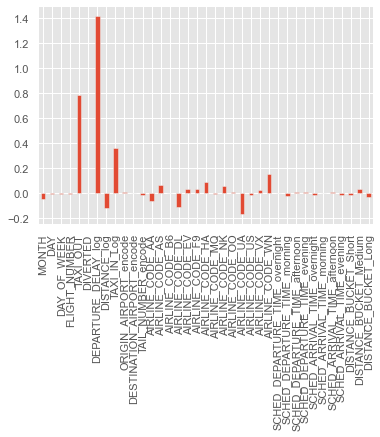

In [56]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_svm_sample.columns)
weights.plot(kind='bar')

#### 1.13.4 SVM with RandomizedSearchCV

In [57]:
# # Source: https://vitalflux.com/randomized-search-explained-python-sklearn-example/

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC
# import scipy as sc

# # Create the pipeline estimator
# pipeline = make_pipeline(StandardScaler(), SVC(random_state=1))

# # Create parameter distribution using scipy.stats module
# param_distributions = [{'svc__C': sc.stats.expon(scale=100),
#                         'svc__gamma': sc.stats.expon(scale=.1),
#                         'svc__kernel': ['rbf']},
#                        {'svc__C': sc.stats.expon(scale=100),
#                         'svc__kernel': ['linear']}]

# # Create an instance of RandomizedSearchCV
# rs = RandomizedSearchCV(estimator=pipeline, param_distributions = param_distributions,
#                         cv = 10, scoring = 'accuracy', refit = True, n_jobs = -1,
#                        random_state=1)
# #
# # Fit the RandomizedSearchCV estimator
# rs.fit(X_train, y_train)

In [58]:
# print('Test Accuracy: %0.3f' % rs.score(X_test, y_test))

## 2. Advantages of Each Model

[10 points] Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

## 3. Feature Importance

> [30 points] Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### 3.1 Weights (Ordered)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| MONTH                          | -0.038797599 |
| DAY                            | -0.004623126 |
| DAY_OF_WEEK                    | -0.043852471 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| TAXI_OUT                       | 0.144409121  |
| DIVERTED                       | 0            |
| DEPARTURE_DELAY_log            | 1.383507196  |
| DISTANCE_log                   | -0.783440119 |
| TAXI_IN_Log                    | 1.264014238  |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| AIRLINE_CODE_AA                | -0.299386121 |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_B6                | -0.084707295 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_EV                | 0.062029928  |
| AIRLINE_CODE_F9                | 0.136878861  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| AIRLINE_CODE_NK                | 0.16124127   |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_UA                | -0.644212585 |
| AIRLINE_CODE_US                | -0.02960251  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_WN                | 0.453810909  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| DISTANCE_BUCKET_Long           | 0.129109945  |

### Weights (Largest to Smallest)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| DEPARTURE_DELAY_log            | 1.383507196  |
| TAXI_IN_Log                    | 1.264014238  |
| AIRLINE_CODE_WN                | 0.453810909  |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_NK                | 0.16124127   |
| TAXI_OUT                       | 0.144409121  |
| AIRLINE_CODE_F9                | 0.136878861  |
| DISTANCE_BUCKET_Long           | 0.129109945  |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_EV                | 0.062029928  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| DIVERTED                       | 0            |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DAY                            | -0.004623126 |
| AIRLINE_CODE_US                | -0.02960251  |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
|        MONTH                   | -0.038797599 |
| DAY_OF_WEEK                    | -0.043852471 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| AIRLINE_CODE_B6                | -0.084707295 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| AIRLINE_CODE_AA                | -0.299386121 |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_UA                | -0.644212585 |
| DISTANCE_log                   | -0.783440119 |

## 4. Support Vectors

[10 points] Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.